In [ ]:
import numpy as np
import matplotlib.pylab as plt

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from simpeg import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

In [ ]:
from matplotlib.colors import Colormap
import pymatsolver
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

In [ ]:
import pickle

In [ ]:
dir_path = "./Case_3.1_truncated_z_225"
topo_filename = dir_path + "/topo_xyz.txt"
data_filename = dir_path + "/dc_data.obs"

In [ ]:
def simpeg_inversion(input_norm):
    p_, qx_, qz_ = input_norm

    csx, csy = 5.0, 5.0
    # Number of core cells in each direction
    ncx, ncy = 200.0 , 45.0
    # Number of padding cells to add in each direction
    npad = 7
    # Vectors of cell lengths in each direction with padding
    hx_ = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
    hy_ = [(csy, npad, -1.5), (csy, ncy)]
    # Create mesh and center it
    mesh = TensorMesh([hx_, hy_], x0="CN")

    # Load data
    topo_xyz = np.loadtxt(str(topo_filename))
    dc_data = read_dcip2d_ubc(data_filename, "volt", "general")

    dc_data.standard_deviation = 0.05 * np.abs(dc_data.dobs) #CHANGE!!!

    # Create 2D topography.
    topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

    # Find cells that lie below surface topography
    ind_active = active_from_xyz(mesh, topo_2d)

    # Extract survey from data object
    survey = dc_data.survey
    # Shift electrodes to the surface of discretized topography
    survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

    # Reset survey in data object
    dc_data.survey = survey

    # Define conductivity model in S/m (or resistivity model in Ohm m)
    air_conductivity = np.log(1e-8)
    background_conductivity = np.log(1e-2)

    # build ind_active
    _ind_active = np.ones((45,200))
    _ind_active = np.pad(_ind_active, ((7,0),(7,7)),  constant_values=(0, 0))
    ind_active_=[]
    for i in _ind_active.flatten():
      if i == 1.:
        ind_active_.append(True)
      else:
        ind_active_.append(False)
    ind_active_=np.array(ind_active_)

    active_map = maps.InjectActiveCells(mesh, ind_active_, np.exp(background_conductivity))

    nC = int(ind_active_.sum()) # Number of cells below the surface< ind_active.shape[0]
    conductivity_map = active_map * maps.ExpMap()
    # Define model (log(True conductivity))
    starting_conductivity_model = background_conductivity * np.ones(nC)

    # Define the problem. Define the cells below topography and the mapping
    simulation = dc.simulation_2d.Simulation2DNodal(
        mesh, survey=survey, sigmaMap=conductivity_map, solver=Solver, storeJ=True
    )

    # Define the data misfit.
    dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

    # Define the regularization (model objective function). Here, 'p' defines the
    # the norm of the smallness term, 'qx' defines the norm of the smoothness
    # in x and 'qz' defines the norm of the smoothness in z.
    regmap = maps.IdentityMap(nP=int(ind_active_.sum()))

    reg = regularization.Sparse(
        mesh,
        indActive=ind_active_,
        reference_model=starting_conductivity_model,
        mapping=regmap,
        gradientType="total",
        alpha_s=.01,
        alpha_x=1,
        alpha_y=1,
    )

#     reg = regularization.Sparse(
#     mesh,
#     active_cells=ind_active_,
#     reference_model=starting_conductivity_model,
#     mapping=regmap,
#     gradient_type="total",
#     alpha_s=0.01,
#     alpha_x=1.,
#     alpha_y=1.,
# )

    reg.reference_model_in_smooth = True  # Include reference model in smoothness

    p = p_
    qx = qx_
    qz = qz_

    reg.norms = [p, qx, qz]

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach.
    opt = optimization.InexactGaussNewton(maxIter=50)

    # Here we define the inverse problem that is to be solved
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    # Apply and update sensitivity weighting as the model updates
    update_sensitivity_weighting = directives.UpdateSensitivityWeights() #Comment out this line when you don't use SensitivityWeight

    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    update_IRLS = directives.Update_IRLS(
        max_irls_iterations=50, minGNiter=1, chifact_start=1.0
    )

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2) #CHANGE TO beta0_ratio=1e1 when inversing for Case 2.X

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

    # Update preconditioner
    update_jacobi = directives.UpdatePreconditioner() #Comment out this line when you don't use SensitivityWeight

    directives_list = [
        update_sensitivity_weighting, #Comment out this line when you don't use SensitivityWeight
        update_IRLS,
        starting_beta,
        save_iteration,
        update_jacobi, #Comment out this line when you don't use SensitivityWeight
    ]

    # Here we combine the inverse problem and the set of directives
    dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

    # Run inversion
    recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)

    norm = LogNorm(vmin=1e-2, vmax=1e-1)

    fig = plt.figure(figsize=(21, 4))

    recovered_conductivity = conductivity_map * recovered_conductivity_model
    recovered_conductivity[~ind_active] = np.NaN

    ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
    mesh.plot_image(
        recovered_conductivity, normal="Y", ax=ax1, grid=False, pcolor_opts={"norm": norm}
    )
    ax1.set_xlim(-350, 350)
    ax1.set_ylim(-125, 0)
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("z (m)")

    ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
    cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)



Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.53e+04  4.77e+04  0.00e+00  4.77e+04    6.97e+03      0              
   1  3.77e+04  3.42e+04  8.12e-02  3.72e+04    2.92e+03      0              
   2  1.88e+04  2.76e+04  2.13e-01  3.16e+04    2.40e+03      0   Skip BFGS  
   3  9.41e+03  2.06e+04  4.93e-01  2.52e+04    1.97e+03      0   Skip BFGS  
   4  4.71e+03  1.43e+04  9.89e-01  1.90e+04    1.48e+03      0   Skip BFGS  
   5  2.35e+03  9.39e+03  1.76e+00  1.35e+04    1.08e+03      0   Skip BFG

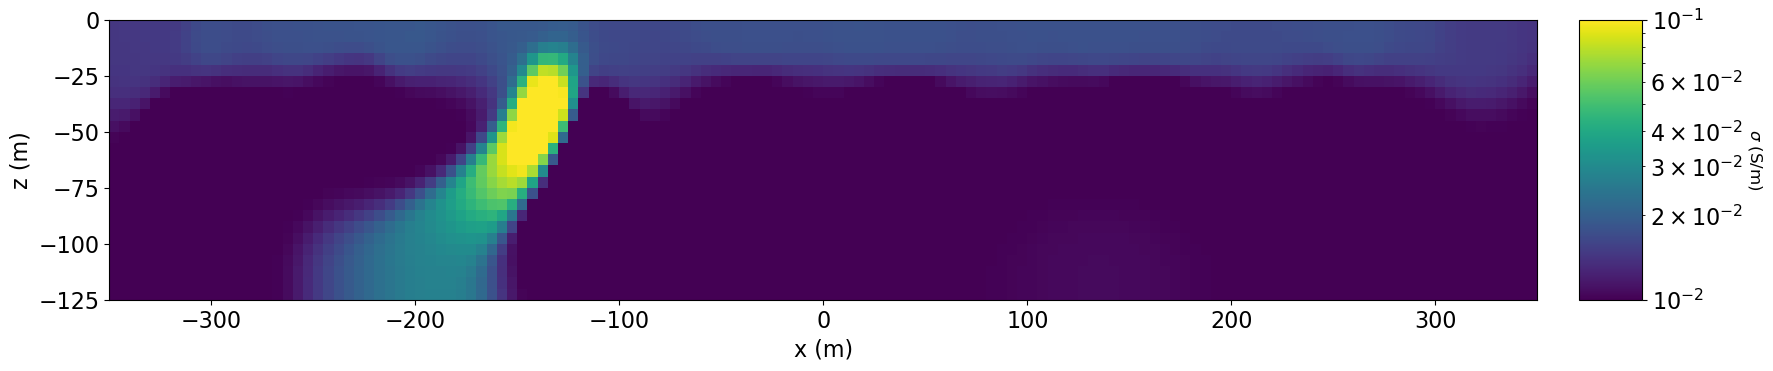

In [ ]:
simpeg_inversion([0,1,1])